LLM use discosure - LLM prompting was used for adding comments, suggestinug better ways to increase accuracy(implementation was done by hand). Also used when I was having issues with docker to help debug error statements and when I was trying to get it running. Also was used to make the README look nice and understandable

# Part 1

In [1]:
# 🔹 Part 1a: Download and Prepare Dataset
# =======================
import os
import random
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.utils import to_categorical

# Update paths to match project structure
DATASET_DIR = "coe379L-sp25/datasets/unit03/Project3"
MODEL_SAVE_DIR = "app/model/best_model"
IMG_SIZE = (128, 128)  # Match the size used in the Flask app

# Create model directory if it doesn't exist
os.makedirs(MODEL_SAVE_DIR, exist_ok=True)

In [2]:
# 🔹 Part 1b: Load and Preprocess Images
# =======================
def load_and_preprocess_images(directory, label):
    images = []
    labels = []
    for filename in os.listdir(directory):
        if filename.endswith(('.jpg', '.jpeg', '.png')):
            img_path = os.path.join(directory, filename)
            try:
                # Load and preprocess image
                img = Image.open(img_path).convert('RGB')
                img = img.resize(IMG_SIZE)
                img_array = np.array(img) / 255.0  # Normalize to [0,1]
                images.append(img_array)
                labels.append(label)
            except Exception as e:
                print(f"Error processing {img_path}: {e}")
    return np.array(images), np.array(labels)

# Load damage and no_damage images
damage_images, damage_labels = load_and_preprocess_images(
    os.path.join(DATASET_DIR, "damage"), 1)
no_damage_images, no_damage_labels = load_and_preprocess_images(
    os.path.join(DATASET_DIR, "no_damage"), 0)

# Combine datasets
X = np.concatenate([damage_images, no_damage_images])
y = np.concatenate([damage_labels, no_damage_labels])

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)

In [3]:
# =======================
# 🔹 Part 1c: Split into Train / Val / Test
# Satisfies: ensure data split for training, validation, and test
# =======================
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)


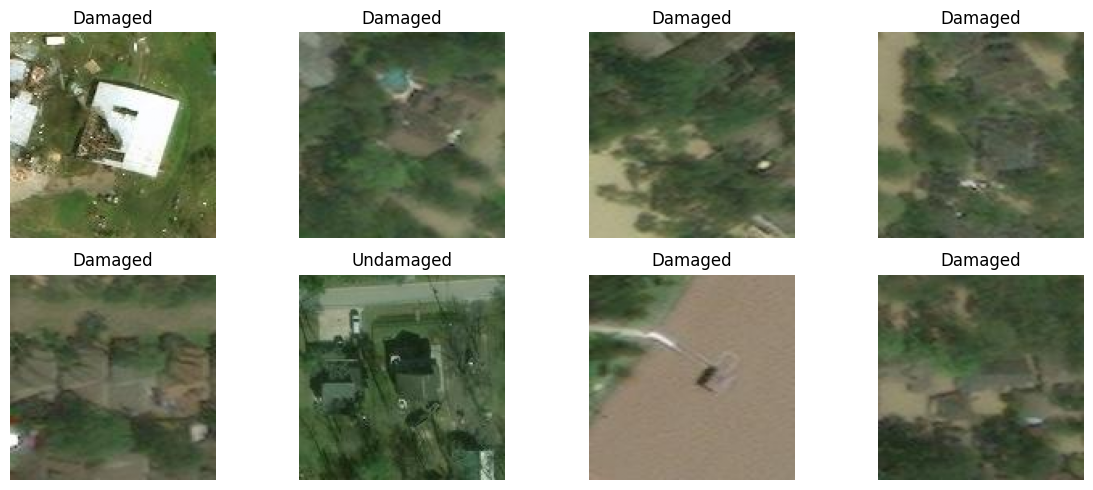

In [4]:
# =======================
# 🔹 Part 1d: Visualize Images
# Satisfies: perform visualization
# =======================
def show_sample_images(images, labels, class_names=["Undamaged", "Damaged"], count=8):
    plt.figure(figsize=(12, 5))
    for i in range(count):
        idx = random.randint(0, len(images) - 1)
        plt.subplot(2, 4, i + 1)
        plt.imshow(images[idx])
        plt.title(class_names[labels[idx]])
        plt.axis("off")
    plt.tight_layout()
    plt.show()

show_sample_images(X_train, y_train)

# Part 2

In [ ]:
# 🔹 Part 2: Build and Train Models
# =======================

# =======================
# 🔸 Part 2a: Define Dense Neural Network (ANN)
# =======================
def create_dense_net():
    model = tf.keras.Sequential([
        tf.keras.layers.Flatten(input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3)),
        tf.keras.layers.Dense(256, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    return model

# =======================
# 🔸 Part 2b: Define Classic LeNet-5
# =======================
def create_lenet5():
    model = tf.keras.Sequential([
        tf.keras.layers.Conv2D(6, kernel_size=5, activation='tanh', input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3)),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.AveragePooling2D(pool_size=2),
        tf.keras.layers.Dropout(0.25),
        
        tf.keras.layers.Conv2D(16, kernel_size=5, activation='tanh'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.AveragePooling2D(pool_size=2),
        tf.keras.layers.Dropout(0.25),
        
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(120, activation='tanh'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(84, activation='tanh'),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    return model

# =======================
# 🔸 Part 2c: Define Modified LeNet-5
# =======================
def create_modified_lenet():
    model = tf.keras.Sequential([
        tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3)),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
        tf.keras.layers.Dropout(0.25),
        
        tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
        tf.keras.layers.Dropout(0.25),
        
        tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.25),
        
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(256, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    return model

# =======================
# 🔸 Part 2d: Training Utility Function
# =======================
def train_model(model, X_train, y_train, X_val, y_val, name="Model"):
    # Add early stopping
    early_stopping = tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=3,
        restore_best_weights=True
    )
    
    print(f"\nTraining {name}...")
    history = model.fit(
        X_train, y_train,
        epochs=15,
        batch_size=32,
        validation_data=(X_val, y_val),
        callbacks=[early_stopping],
        verbose=1
    )
    return history

# =======================
# 🔸 Part 2e: Invert Labels and Train Models
# =======================
# Invert the labels to match the Flask app's expectations
y_train = 1 - y_train
y_val = 1 - y_val
y_test = 1 - y_test

print("Training Dense Neural Network...")
dense_net = create_dense_net()
dense_history = train_model(dense_net, X_train, y_train, X_val, y_val, name="Dense ANN")

print("\nTraining LeNet-5...")
lenet5_net = create_lenet5()
lenet_history = train_model(lenet5_net, X_train, y_train, X_val, y_val, name="LeNet-5")

print("\nTraining Modified LeNet-5...")
mod_lenet_net = create_modified_lenet()
mod_history = train_model(mod_lenet_net, X_train, y_train, X_val, y_val, name="Modified LeNet-5")

# =======================
# 🔸 Part 2f: Evaluate Models
# =======================
def evaluate_model(model, X_test, y_test, label):
    loss, acc = model.evaluate(X_test, y_test, verbose=0)
    print(f"{label} - Test Accuracy: {acc:.4f}")
    return acc

print("\nEvaluating models on test set:")
dense_acc = evaluate_model(dense_net, X_test, y_test, "Dense ANN")
lenet_acc = evaluate_model(lenet5_net, X_test, y_test, "LeNet-5")
mod_lenet_acc = evaluate_model(mod_lenet_net, X_test, y_test, "Modified LeNet-5")

# =======================
# 🔹 Part 3: Visualization and Model Selection
# =======================
def plot_training_curves(histories, titles):
    plt.figure(figsize=(15, 5))
    for i, (history, title) in enumerate(zip(histories, titles), 1):
        plt.subplot(1, 3, i)
        plt.plot(history.history['accuracy'], label='Train')
        plt.plot(history.history['val_accuracy'], label='Val')
        plt.title(f"{title} Accuracy")
        plt.xlabel("Epoch")
        plt.ylabel("Accuracy")
        plt.legend()
        plt.grid(True)
    plt.tight_layout()
    plt.show()

# Plot all training curves
plot_training_curves(
    [dense_history, lenet_history, mod_history],
    ["Dense ANN", "LeNet-5", "Modified LeNet-5"]
)

# Save the best model based on test accuracy
best_acc = max(dense_acc, lenet_acc, mod_lenet_acc)
if best_acc == dense_acc:
    best_model = dense_net
    best_name = "Dense ANN"
elif best_acc == lenet_acc:
    best_model = lenet5_net
    best_name = "LeNet-5"
else:
    best_model = mod_lenet_net
    best_name = "Modified LeNet-5"

print(f"\nBest model is {best_name} with test accuracy: {best_acc:.4f}")
best_model.save(MODEL_SAVE_DIR)
print(f"Best model saved to {MODEL_SAVE_DIR}")

Training model...
Epoch 1/15
467/467 [==============================] - 101s 215ms/step - loss: 0.2527 - accuracy: 0.9076 - val_loss: 1.4247 - val_accuracy: 0.6727
Epoch 2/15
467/467 [==============================] - 102s 218ms/step - loss: 0.1314 - accuracy: 0.9485 - val_loss: 0.6185 - val_accuracy: 0.8875
Epoch 3/15
467/467 [==============================] - 103s 221ms/step - loss: 0.0999 - accuracy: 0.9631 - val_loss: 1.4986 - val_accuracy: 0.6652
Epoch 4/15
467/467 [==============================] - 103s 220ms/step - loss: 0.0784 - accuracy: 0.9709 - val_loss: 0.7218 - val_accuracy: 0.7277
Epoch 5/15
467/467 [==============================] - 103s 221ms/step - loss: 0.0571 - accuracy: 0.9799 - val_loss: 0.4925 - val_accuracy: 0.8465
Epoch 6/15
467/467 [==============================] - 103s 222ms/step - loss: 0.0541 - accuracy: 0.9811 - val_loss: 0.7480 - val_accuracy: 0.7305
Epoch 7/15
467/467 [==============================] - 104s 222ms/step - loss: 0.0420 - accuracy: 0.9857 - 